Fitting population params so waterfall plot matches the real clinical trial one. Using Model ../final/pca_models/MLPRegressor_600_100_40_11_-7_6.pickle

In [1]:
import numpy as np

POPULATION_SIZE = 100_000
DISTRIBUTION_PARAMETERS = np.array(
    [
        [0.05, 0.5],
        [-2.436, 0.62335],
        [-2.58098, 0.69689],
        [0.2, 0.4],
        [0.005, 0.01],
        [0.01155, 0.0231],
        [0.15, 0.30],
        [150, 300],
        [0.75, 1.5],
        [1e-5, 0.01],
    ]
)
LOGNORMAL_PARAMETERS = (1, 2)

np.random.seed(seed=42)

In [2]:
# Loading model (including scaler, pca, dropping column 0 and transforming orders of magnitue to absolute values)

import time
from sklearn.preprocessing import MinMaxScaler
import pickle
from pathlib import Path


class CustomScaler:
    def __init__(self):
        super().__init__()
        self.scaler = MinMaxScaler()
        self.plot_loval = [0.0] * len(LOGNORMAL_PARAMETERS)
        self.plot_hival = [1.0] * len(LOGNORMAL_PARAMETERS)

    def transform(self, x: np.ndarray, copy=None) -> np.ndarray:
        res = self.scaler.transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = (x[:, parameter_index] - self.plot_loval[i]) / (self.plot_hival[i] - self.plot_loval[i])

        return res

    def fit(self, x, copy=None):
        self.scaler.fit(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            column_values = x[:, parameter_index]

            quantile_1, quantile_3 = np.quantile(column_values, [0.25, 0.75], axis=0)
            iqr = quantile_3 - quantile_1

            loval = quantile_1 - 1.5 * iqr
            hival = quantile_3 + 1.5 * iqr

            wiskhi = np.compress(column_values <= hival, column_values)
            wisklo = np.compress(column_values >= loval, column_values)
            actual_hival = np.max(wiskhi)
            actual_loval = np.min(wisklo)

            self.plot_loval[i] = actual_loval
            self.plot_hival[i] = actual_hival

        return self

    def inverse_transform(self, x, copy=None):
        res = self.scaler.inverse_transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = x[:, parameter_index] * (self.plot_hival[i] - self.plot_loval[i]) + self.plot_loval[i]
        return res
    
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from threadpoolctl import threadpool_limits
from cpuinfo import get_cpu_info
from sklearn.decomposition import PCA


with Path(f"../final/scaler.pickle").open("rb") as scaler_file:
    scaler = pickle.load(scaler_file)

with Path(f"../final/pca/11_-7.pickle").open("rb") as opened_file:
    pca = pickle.load(opened_file)

with Path("../final/pca_models/MLPRegressor_600_100_40_11_-7_6.pickle").open("rb") as opened_file:
    regressor = pickle.load(opened_file)
    
def drop_treatment(input_data: np.ndarray) -> np.ndarray:
    """Drops treatment data from the dataset"""
    if input_data.shape[1] == 11:
        return input_data[:, 1:]

    return input_data

def predict(*args):
    return regressor.predict(*args)

def output_untransform(transformed_outputs: np.array) -> np.array:
    lower_limits = transformed_outputs <= -7
    z = 10 ** transformed_outputs
    z[lower_limits] = 0
    return z

model = make_pipeline(
    FunctionTransformer(drop_treatment),
    scaler,
    FunctionTransformer(predict),
    FunctionTransformer(pca.inverse_transform),
    FunctionTransformer(output_untransform)
)

In [3]:
# Generating parameters for each virtual patient in virtual population
# Note: To get virtual population with different distribution the alredy generated parameters are adjusted to the new distribution.


def generate_patient_indicators(size: int) -> np.ndarray:
    """
    Generates patient indicators.

    :param size: number of patients
    :return:
    """
    patient_indicators_arr = np.zeros((size, 11))
    patient_indicators_arr[:, 0] = np.ones(
        size
    )  # first indicator tells if treatment was applied

    for i, distribution_parameters in enumerate(DISTRIBUTION_PARAMETERS):
        if i in LOGNORMAL_PARAMETERS:
            patient_indicators_arr[:, i + 1] = np.random.lognormal(
                mean=distribution_parameters[0],
                sigma=distribution_parameters[1],
                size=size,
            )
        else:
            patient_indicators_arr[:, i + 1] = np.random.uniform(
                low=distribution_parameters[0],
                high=distribution_parameters[1],
                size=size,
            )

    return patient_indicators_arr

start_time = time.time()
patient_indicators = generate_patient_indicators(POPULATION_SIZE)
patient_indicators_generation_time_s = time.time() - start_time

print(
    f"Generated {POPULATION_SIZE} sets of patients indicators in {patient_indicators_generation_time_s} seconds"
)

Generated 100000 sets of patients indicators in 0.00875401496887207 seconds


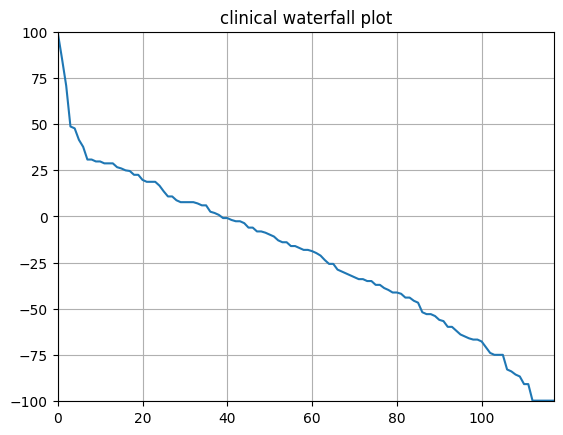

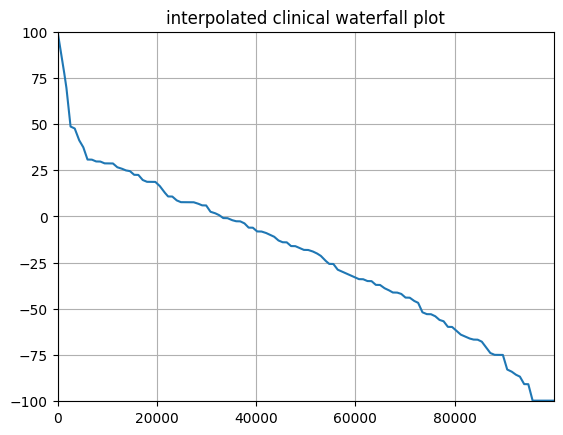

In [4]:
CLINICAL_WATERFALL_PLOT = '../final/Chatterjee_etal_2016_10mgperkg_Waterfall.csv'
population_data = np.loadtxt(CLINICAL_WATERFALL_PLOT, delimiter=",", skiprows=1, usecols=(1,))

import matplotlib.pyplot as plt

plt.title("clinical waterfall plot")
plt.grid()
plt.plot(population_data)
plt.xlim([0, 117])
plt.ylim([-100, 100])
plt.show()


from scipy import interpolate
waterfall_plot_interpolation = interpolate.interp1d(
    np.arange(0, len(population_data)) / (len(population_data) - 1), population_data
)
plt.title("interpolated clinical waterfall plot")
plt.grid()
plt.plot(waterfall_plot_interpolation(np.arange(POPULATION_SIZE) / (POPULATION_SIZE - 1)))
plt.xlim([0, POPULATION_SIZE - 1])
plt.ylim([-100, 100])
plt.show()



In [5]:
class TooManyDroppedCasesError(Exception):
    """Exception raised when too many cases were dropped by the model."""


class InvalidParametersError(Exception):
    """Exception raised when parameters passed to objective function are invalid"""


def validate_params(relative_params):
    for column in range(len(DISTRIBUTION_PARAMETERS)):
        i = column
        if column not in LOGNORMAL_PARAMETERS:
            absolute_params = DISTRIBUTION_PARAMETERS[column]
            low = absolute_params[0] + relative_params[i * 2] * (absolute_params[1] - absolute_params[0])
            high = absolute_params[0] + relative_params[i * 2 + 1] * (absolute_params[1] - absolute_params[0])

            if relative_params[i * 2] < -0.02 or relative_params[i * 2 + 1] > 1.02:
                raise InvalidParametersError(f"{(low, high)} out of range on column {column} ({relative_params[2 * i]}, {relative_params[2 * i + 1]})")

            if relative_params[2 * i] >= relative_params[2 * i + 1]:
                raise InvalidParametersError(f"negative range at column {column} ({relative_params[2 * i]}, {relative_params[2 * i + 1]})")

def initial_relative_params(ratio):
    params = []
    for column in range(len(DISTRIBUTION_PARAMETERS)):
        if column in LOGNORMAL_PARAMETERS:
            params.append(0.0)
            params.append(ratio)
        else:
            params.append(1.0 - ratio)
            params.append(ratio)

    return np.array(params)
                
def adjust_patient_indicators(indicators, relative_params):
    global patient_indicators
    
    for i in range(len(DISTRIBUTION_PARAMETERS)):
        if i in LOGNORMAL_PARAMETERS:
            indicators[:, i + 1] = np.exp(
                (np.log(patient_indicators[:, i + 1]) - DISTRIBUTION_PARAMETERS[i][0])
                * (relative_params[2 * i + 1] / DISTRIBUTION_PARAMETERS[i][1])
                + DISTRIBUTION_PARAMETERS[i][0]
                + relative_params[2 * i]
            )
        else:
            indicators[:, i + 1] = (
                DISTRIBUTION_PARAMETERS[i][0]
                + relative_params[i * 2] * (DISTRIBUTION_PARAMETERS[i][1] - DISTRIBUTION_PARAMETERS[i][0])
                + (relative_params[2 * i + 1] - relative_params[2 * i]) * (patient_indicators[:, i + 1] - DISTRIBUTION_PARAMETERS[i][0])
            )
    return indicators

In [6]:
def waterfall_plot(indicators):
    time_profiles = model.transform(indicators)
    
    max_tumor_sizes = time_profiles.max(axis=1)
    final_tumor_sizes = time_profiles[:, -1]
    final_tumor_sizes[final_tumor_sizes < 0] = 0

    initial_tumor_sizes = indicators[:, 10]
    max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
    percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes

    dropped_count = int(np.sum(max_percent_change > 100.0))
    if dropped_count / POPULATION_SIZE > 0.8:
        raise TooManyDroppedCasesError(f"Dropped {dropped_count} out of {POPULATION_SIZE} ({dropped_count * 100 / POPULATION_SIZE:.2f}%) time profiles")
    percent_change = percent_change[max_percent_change <= 100.0]
    percent_change[::-1].sort()
    
    return percent_change

In [7]:
import time
minimize_history = []
indicators = np.copy(patient_indicators)

def minimize_objective(relative_params, use_regularization=True):
    global minimize_history, indicators
    
    try:
        validate_params(relative_params)
        adjust_patient_indicators(indicators, relative_params)
        
        virtual_waterfall_plot = waterfall_plot(indicators)
        interpolated_waterfall_plot = waterfall_plot_interpolation(np.arange(virtual_waterfall_plot.shape[0]) / (virtual_waterfall_plot.shape[0] - 1))

        regularization_term = 0.5
        regularization = np.power(np.prod([
            regularization_term / min(regularization_term, relative_params[2 * i + 1] - relative_params[2 * i])
            for i in range(len(DISTRIBUTION_PARAMETERS))
            if i not in LOGNORMAL_PARAMETERS
        ]), 1.0/(len(DISTRIBUTION_PARAMETERS) - len(LOGNORMAL_PARAMETERS)))
        
        distance = np.linalg.norm(interpolated_waterfall_plot - virtual_waterfall_plot)
        minimize_history.append((relative_params, regularization * distance, regularization, distance, time.time()))
        # print(f"{len(minimize_history)} d: {distance} r: {regularization} r*d: {regularization*distance}")
    except Exception as err:
        print(str(err))
        minimize_history.append((relative_params, float("inf"), float("inf"), float("inf"), time.time()))
    
    return minimize_history[-1][1 if use_regularization else 3]

def minimize_objective_no_regularization(relative_params):
    return minimize_objective(relative_params, False)

In [8]:
import scipy.optimize
from cpuinfo import get_cpu_info
import json
import math

bounds = scipy.optimize.Bounds(
    lb=[-math.inf if i // 2 in LOGNORMAL_PARAMETERS else -0.02 for i in range(len(DISTRIBUTION_PARAMETERS) * 2)],
    ub=[math.inf if i // 2 in LOGNORMAL_PARAMETERS else 1.02 for i in range(len(DISTRIBUTION_PARAMETERS) * 2)]
)

constraints = [{
    'type': 'ineq',
    'fun': lambda x: [((x[2 * i + 1] - x[2 * i]) if (x[2 * i + 1] != x[2 * i]) else -1) for i in range(len(DISTRIBUTION_PARAMETERS)) if i not in LOGNORMAL_PARAMETERS] 
}]

results = {}
minimize_models = (("Nelder-Mead", ({
        "method": "Nelder-Mead",
        "bounds": bounds,
        "options": {
            "maxiter": 800,
        }
    },)),
    ("Nelder-Mead_adaptive", ({
        "method": "Nelder-Mead",
        "bounds": bounds,
        "options": {
            "maxiter": 600,
            "adaptive": True
        }
    },)),
    ("Nelder-Mead_restart", ({
        "method": "Nelder-Mead",
        "bounds": bounds,
        "options": {
            "maxiter": 350,
            "adaptive": True
        }
    },{
        "method": "Nelder-Mead",
        "bounds": bounds,
        "options": {
            "maxiter": 250,
            "adaptive": True
        }
    },{
        "method": "Nelder-Mead",
        "bounds": bounds,
        "options": {
            "maxiter": 150,
            "adaptive": True
        }
    },{
        "method": "Nelder-Mead",
        "bounds": bounds,
        "options": {
            "maxiter": 100,
            "adaptive": True
        }
    },)),
    ("Powell", ({
        "method": "Powell",
        "bounds": bounds,
        "options": {
            "maxiter": 1000,
        }
    },)),
    ("BFGS", ({
        "method": "BFGS",
        "options": {
            "maxiter": 1000,
        }
    },)),
    ("SLSQP", ({
        "method": "SLSQP",
        "bounds": bounds,
        "constraints": constraints,
        "options": {
            "maxiter": 600,
        }
    },))
        )

for method_name, options_list in minimize_models:
    minimize_path = Path(f"../final/minimize_{method_name}.json")
    if minimize_path.is_file():
        with minimize_path.open("r") as opened_file:
            metadata = json.load(opened_file)
            results[method_name] = metadata["minimize_history"]
        continue

    minimize_history = []
    start_time = time.time()
    
    params = initial_relative_params(0.95)
    result = None
    for options in options_list:
        result = scipy.optimize.minimize(
            minimize_objective,
            params,
            **options,
        )
        params = result.x
    
    results[method_name] = [(p.tolist(), v, v_r, v_d, int(t - start_time)) for p, v, v_r, v_d, t in minimize_history]
    
    with minimize_path.open("w") as opened_file:
        opened_file.write(json.dumps({
            "cpu_info": {key: get_cpu_info()[key] for key in ["arch", "bits", "brand_raw", "count"]},
            "minimize_options": [o["options"] for o in options_list],
            "population_size": POPULATION_SIZE,
            "minimize_history": results[method_name],
            "model": "pca_models/MLPRegressor_600_100_40_11_-7_6.pickle"
        }, sort_keys=True, indent=4))
    

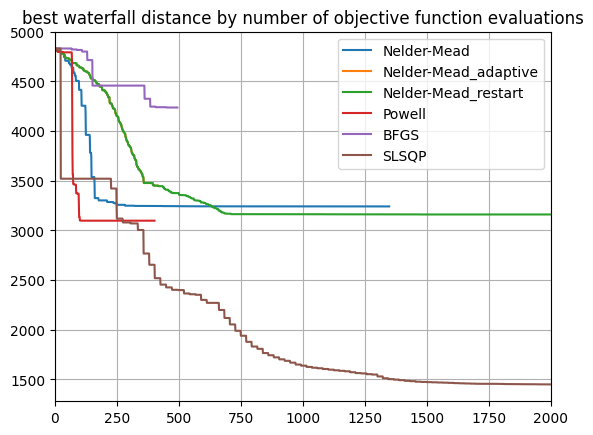

In [9]:
import itertools
import operator

plt.title("best waterfall distance by number of objective function evaluations")
plt.grid()
for method_name in ("Nelder-Mead", "Nelder-Mead_adaptive", "Nelder-Mead_restart", "Powell", "BFGS", "SLSQP"):
    plt.plot(list(itertools.accumulate((x[1] for x in results[method_name]), min)), label=method_name)
plt.legend()
plt.xlim((0, 2000))
plt.show()

In [10]:
for method_name, options_list in minimize_models:
    method_name = f"no_regularization_{method_name}"
    minimize_path = Path(f"../final/minimize_{method_name}.json")
    if minimize_path.is_file():
        with minimize_path.open("r") as opened_file:
            metadata = json.load(opened_file)
            results[method_name] = metadata["minimize_history"]
        continue

    minimize_history = []
    start_time = time.time()
    
    params = initial_relative_params(0.95)
    result = None
    for options in options_list:
        result = scipy.optimize.minimize(
            minimize_objective_no_regularization,
            params,
            **options,
        )
        params = result.x
    
    results[method_name] = [(p.tolist(), v, v_r, v_d, int(t - start_time)) for p, v, v_r, v_d, t in minimize_history]
    
    with minimize_path.open("w") as opened_file:
        opened_file.write(json.dumps({
            "cpu_info": {key: get_cpu_info()[key] for key in ["arch", "bits", "brand_raw", "count"]},
            "minimize_options": [o["options"] for o in options_list],
            "population_size": POPULATION_SIZE,
            "minimize_history": results[method_name],
            "model": "pca_models/MLPRegressor_600_100_40_11_-7_6.pickle"
        }, sort_keys=True, indent=4))

/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 81571 out of 100000 (81.57%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 80588 out of 100000 (80.59%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 80139 out of 100000 (80.14%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 86650 out of 100000 (86.65%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 82847 out of 100000 (82.85%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 81034 out of 100000 (81.03%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 80305 out of 100000 (80.31%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 80028 out of 100000 (80.03%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 80368 out of 100000 (80.37%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 83889 out of 100000 (83.89%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 85979 out of 100000 (85.98%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 87158 out of 100000 (87.16%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 87885 out of 100000 (87.89%) time profiles
negative range at column 3 (0.9620427863991251, 0.95)
negative range at column 3 (0.9841804721014217, 0.95)
negative range at column 3 (0.9978623142977036, 0.95)
negative range at column 3 (1.0063181578037184, 0.95)
negative range at column 3 (1.0115441564939853, 0.95)
negative range at column 3 (1.0147740013097328, 0.95)
negative range at column 3 (1.0167701551842525, 0.95)
negative range at column 3 (1.0180038461254806, 0.95)
negative range at column 3 (1.0187663090587722, 0.95)
negative range at column 3 (1.0192375370667084, 0.95)
negative range at column 3 (1.0195287719920638, 0.95)
negative range at column 3 (1.0197087650746446, 0.95)
negative range at column 3 (1.0198200069174193, 0.95)
negative range at column 3 (1.0198887581572254, 0.95)
negative range at column 3 (1.0199312487601941, 0.95)
negative range at column 3 (1.0199645964799329, 0.95)
negative range at column 3 (1.0199645964799329, 0.37724465170010935)
negative range a

(0.32814606950735153, 0.5739923476786417) out of range on column 0 (0.6181023766830034, 1.1644274392858702)
(0.32814607621287406, 0.5739923476786417) out of range on column 0 (0.6181023915841646, 1.1644274392858702)
(0.32814606950735153, 0.5739923543841642) out of range on column 0 (0.6181023766830034, 1.1644274541870314)
(0.32814606950735153, 0.5739923476786417) out of range on column 0 (0.6181023766830034, 1.1644274392858702)
(0.32814606950735153, 0.5739923476786417) out of range on column 0 (0.6181023766830034, 1.1644274392858702)
(0.32814606950735153, 0.5739923476786417) out of range on column 0 (0.6181023766830034, 1.1644274392858702)
(0.32814606950735153, 0.5739923476786417) out of range on column 0 (0.6181023766830034, 1.1644274392858702)
(0.32814606950735153, 0.5739923476786417) out of range on column 0 (0.6181023766830034, 1.1644274392858702)
(0.32814606950735153, 0.5739923476786417) out of range on column 0 (0.6181023766830034, 1.1644274392858702)
(0.32814606950735153, 0.5739

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


(0.32814606950735153, 0.5739923476786417) out of range on column 0 (0.6181023766830034, 1.1644274392858702)
(0.2003230347536758, 0.5257461738393209) out of range on column 0 (0.3340511883415017, 1.0572137196429352)
(0.004682444846098144, 0.009158968763993521) out of range on column 4 (-0.06351103078037121, 0.8317937527987043)
(0.004682444846098144, 0.009158968763993521) out of range on column 4 (-0.06351103078037121, 0.8317937527987043)
(0.004682444846098144, 0.009158968763993521) out of range on column 4 (-0.06351103078037121, 0.8317937527987043)
(0.004682444846098144, 0.009158968763993521) out of range on column 4 (-0.06351103078037121, 0.8317937527987043)
(0.004682444846098144, 0.009158968763993521) out of range on column 4 (-0.06351103078037121, 0.8317937527987043)
(0.004682444846098144, 0.009158968763993521) out of range on column 4 (-0.06351103078037121, 0.8317937527987043)
(0.004682444846098144, 0.009158968763993521) out of range on column 4 (-0.06351103078037121, 0.831793752798

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


(0.004819202893989403, 0.009302228093345601) out of range on column 4 (-0.03615942120211942, 0.8604456186691203)
(0.004827277962567455, 0.0092861872183442) out of range on column 4 (-0.034544407486508985, 0.85723744366884)
(0.004827277962567455, 0.0092861872183442) out of range on column 4 (-0.034544407486508985, 0.85723744366884)
(0.004827277962567455, 0.0092861872183442) out of range on column 4 (-0.034544407486508985, 0.85723744366884)
(0.004827277962567455, 0.0092861872183442) out of range on column 4 (-0.034544407486508985, 0.85723744366884)
(0.004827277962567455, 0.0092861872183442) out of range on column 4 (-0.034544407486508985, 0.85723744366884)
(0.004827277962567455, 0.0092861872183442) out of range on column 4 (-0.034544407486508985, 0.85723744366884)
(0.004827277962567455, 0.0092861872183442) out of range on column 4 (-0.034544407486508985, 0.85723744366884)
(0.004827277962567455, 0.0092861872183442) out of range on column 4 (-0.034544407486508985, 0.85723744366884)
(0.0048

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


(0.004827277962567455, 0.0092861872183442) out of range on column 4 (-0.034544407486508985, 0.85723744366884)
(0.004874725811013962, 0.009348140579836272) out of range on column 4 (-0.02505483779720765, 0.8696281159672544)
(0.004898449735237215, 0.009379117260582309) out of range on column 4 (-0.020310052952556983, 0.8758234521164617)
negative range at column 4 (-0.018995996457488173, -0.019134428864890696)
Input X contains infinity or a value too large for dtype('float64').


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1907790191.py:40: RuntimeWarning: overflow encountered in exp
  indicators[:, i + 1] = np.exp(
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folde

Dropped 96061 out of 100000 (96.06%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

negative range at column 0 (1.019827953611899, -0.019946955798027965)
Input X contains infinity or a value too large for dtype('float64').


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1907790191.py:40: RuntimeWarning: overflow encountered in exp
  indicators[:, i + 1] = np.exp(
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folde

Dropped 81167 out of 100000 (81.17%) time profiles
negative range at column 3 (1.0190342708909668, -0.01623182009100177)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 92254 out of 100000 (92.25%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, 1.02)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 88850 out of 100000 (88.85%) time profiles


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, 1.02)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs


Dropped 95225 out of 100000 (95.22%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

negative range at column 3 (1.0161451848095684, -0.010339639688927038)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (-0.0197207470678315, -0.02)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.015388378266227, 1.0095497308517205)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.4005065042899275, -0.019816921933046183)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 3 (1.02, -0.02)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, 1.02)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (-0.019818096052834473, -0.01988540334706168)
negative range at column 0 (1.019872417928497, 1.0198526491525948)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.3092620867237433, -0.019992352867868934)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 3 (1.0170579510724076, -0.016753779995235085)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, -0.019983673168615157)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.05252984134332265, -0.019459263589234332)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.1910056758044731, -0.02)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, 1.019872047569622)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.2799350362105101, -0.02)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.557137143544638, -0.01999047964696865)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (0.6588696695965729, -0.01999946544103326)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.31946593410494656, -0.01999125587031314)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (0.1357619789713605, -0.0199984026511848)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, -0.01994359594102646)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (-0.02, -0.02)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.2609259741393367, -0.02)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (0.14182884110578337, -0.02)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (0.033799055403397865, -0.02)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (-0.01999999999999999, -0.02)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 6 (0.41132282342840637, 0.3683966798419904)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.27057113564279556, 0.11603616052958288)
negative range at column 9 (0.3904451370186923, 0.3230004876620442)
negative range at column 9 (0.3605865791210261, 0.3573005364282486)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.27966874365280725, 0.07665799095730419)
negative range at column 9 (0.38876330966157285, 0.36451995965278977)
negative range at column 0 (0.31494001419205064, -0.019980549437957018)
negative range at column 9 (0.38539391940925766, 0.35191148938456923)
negative range at column 9 (0.3631846757087875, 0.36018968376415195)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.300138118807409, 0.23509218968423123)
negative range at column 9 (0.3808344757537034, 0.357663796440521)
negative range at column 9 (0.3629508237802368, 0.36068213252595127)
negative range at column 9 (0.3611624585828901, 0.3609839661344943)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (-0.01999999999999999, -0.01999999999999999)
negative range at column 4 (-0.018524016219359868, -0.018623282511509798)
negative range at column 8 (0.38833617567435214, 0.38776678333093056)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (-0.01999999999999999, -0.02)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 84659 out of 100000 (84.66%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

negative range at column 0 (1.02, 1.02)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

negative range at column 0 (1.0199989128855553, -0.019999731107857577)
negative range at column 6 (0.47591963551016175, 0.4311317808339557)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, -0.02)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

negative range at column 0 (1.019999809635973, -0.019999906591398275)
negative range at column 0 (1.019993819676444, -0.019995837764275826)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 95656 out of 100000 (95.66%) time profiles
negative range at column 0 (1.0199108314922756, -0.019931946321894323)
negative range at column 6 (0.4653011368006585, 0.4085745439375016)
negative range at column 0 (1.0199954015896755, -0.019996942356612424)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, -0.02)
negative range at column 6 (0.41274043496895574, 0.4032698671710486)
negative range at column 9 (0.33841774997135593, 0.33424074449867275)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.0199999774535946, -0.02)
negative range at column 6 (0.46061466106713084, 0.4028465973038776)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 5 (1.02, 1.02)
negative range at column 6 (0.41475393024689544, 0.39861813248680866)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.3606257436810879, -0.01999999718487855)
negative range at column 6 (0.4515095774648108, 0.39443195087275634)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, -0.02)
negative range at column 8 (0.3755333088637309, 0.3641884216987366)
negative range at column 0 (0.3420338344470932, -0.01999996960945616)
negative range at column 6 (0.4323473793564807, 0.3924202555040801)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.0199999882411344, -0.02)
negative range at column 9 (0.3176936206827402, 0.3053715444610398)
negative range at column 4 (0.022360081895520093, -0.01999999999999999)
negative range at column 9 (0.3287871096777885, 0.30943276958722454)
negative range at column 0 (0.5999977430873398, -0.019999986884541188)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (-0.01999999999999999, -0.01999999999999999)
negative range at column 9 (0.33104378120922284, 0.3107144862052009)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (-0.01999919476806425, -0.019999276925053933)
negative range at column 9 (0.32970490324046037, 0.3119799269455111)
negative range at column 9 (0.326046610475425, 0.3249149539384039)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 5 (-0.01999999542357056, -0.02)
negative range at column 8 (0.44209215937877033, 0.4175630067704076)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 5 (-0.02, -0.02)
negative range at column 8 (0.44787123778498267, 0.4131873631313906)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 5 (1.0199999924341865, 1.019999902311012)
negative range at column 9 (0.33066258683872757, 0.3209530011646993)
negative range at column 9 (0.3262846645637239, 0.3256705511515547)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (-0.01999998632882638, -0.019999987762184257)
negative range at column 9 (0.3284717276495236, 0.32624006796195104)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 7 (1.02, 1.02)
negative range at column 9 (0.33032315164310405, 0.32455584659071984)
negative range at column 9 (0.3265307372451086, 0.3259924587573422)
negative range at column 9 (0.32615149580530906, 0.32613611997400443)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 5 (-0.02, -0.02)
negative range at column 7 (0.786995542662368, 0.7811659438186902)
negative range at column 9 (0.32697008307545905, 0.32563619076281713)
negative range at column 9 (0.32619922280274216, 0.3260990565623853)
negative range at column 5 (1.02, -0.019999919065275207)
negative range at column 9 (0.3271600066396592, 0.32646763878221563)
negative range at column 9 (0.32622592376188936, 0.32617757270632947)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 5 (1.019997025971545, -0.0199961171758547)
negative range at column 8 (0.4509531749793243, 0.41484378125805316)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 5 (-0.02, -0.02)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 5 (1.019998494505685, -0.02)
negative range at column 8 (0.4193795784131576, 0.3674458959364785)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (-0.02, -0.02)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (-0.02, -0.02)
negative range at column 9 (0.3297749183972067, 0.32921290005051457)
negative range at column 9 (0.3298104553142982, 0.32692363599051205)
negative range at column 9 (0.3285904935408118, 0.3257691341130615)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, 1.02)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

negative range at column 3 (1.0199999120290035, 1.0199998497886313)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 93158 out of 100000 (93.16%) time profiles
negative range at column 3 (-0.01999985976980241, -0.019999975661538882)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, 1.02)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 80105 out of 100000 (80.11%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, 1.0199999923428507)
negative range at column 6 (0.4253260366467513, 0.3719295369037789)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, 1.0199999909818858)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

negative range at column 0 (1.02, 1.02)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

negative range at column 0 (1.02, 1.02)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 98772 out of 100000 (98.77%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

negative range at column 0 (1.02, 1.02)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 96780 out of 100000 (96.78%) time profiles


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

negative range at column 0 (-0.019997517752740113, -0.019997657040709882)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 85495 out of 100000 (85.50%) time profiles


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (-0.02, -0.02)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in divide
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in divide
  percent_change = 100.0 * (final_tumor_

Dropped 82303 out of 100000 (82.30%) time profiles
negative range at column 5 (-0.019999990459412975, -0.01999999092204635)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (-0.02, -0.02)


/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/1401460667.py:79: RuntimeWarning: overflow encountered in power
  z = 10 ** transformed_outputs
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:9: RuntimeWarning: overflow encountered in multiply
  max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_22735/3647229099.py:10: RuntimeWarning: overflow encountered in multiply
  percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 9 (-0.01999988950238596, -0.019999889950084948)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.0128854107068412, 1.0097732197844953)
negative range at column 9 (0.39202192804552316, 0.3423018159022957)
negative range at column 9 (0.32985471099342467, 0.326489478772589)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, 1.02)
negative range at column 6 (0.36728038487350617, 0.33852082427737384)
negative range at column 9 (0.32514258833453913, 0.3213002790889827)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.2563278800099163, -0.02)
negative range at column 6 (0.4293950921252655, 0.34846174715857675)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (-0.019999999999999997, -0.019999999999999997)
negative range at column 6 (0.43219342683221473, 0.3385389230475455)
negative range at column 6 (0.3765204838872343, 0.37136152265681327)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.9491477496062404, -0.01997074224157691)
negative range at column 8 (0.5974551484940563, 0.5380222396373162)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, 1.0199932348558067)
negative range at column 5 (0.2818039288640054, 0.2668965714757497)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 6 (0.4240940770298396, 0.3023950457222401)
negative range at column 6 (0.37702893421524597, 0.3696172387815063)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, 1.0199997497892577)
negative range at column 8 (0.602311148052441, 0.5725239254664699)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (-0.019999999999999997, -0.02)
negative range at column 9 (0.31846329704796955, 0.30233945988077493)
negative range at column 0 (1.0198030077212188, 1.0197779997513776)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.9809551719535661, -0.02)
negative range at column 5 (-0.019947457706339766, -0.019952979501861368)
negative range at column 6 (0.3772073861307466, 0.3630412631059612)
negative range at column 5 (-0.019844003897501683, -0.019859720699021477)
negative range at column 0 (0.5879415446098162, 0.5761459255321877)
negative range at column 6 (0.36906187064237655, 0.3671925417443284)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (-0.02, -0.02)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 5 (-0.01999999999999999, -0.02)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 7 (-0.02, -0.02)
negative range at column 9 (0.3161273722854187, 0.29938596120356575)
negative range at column 0 (0.629125573586197, 0.6252049855646318)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 4 (-0.02, -0.02)
negative range at column 0 (0.5847804503895303, 0.5635152358828465)
negative range at column 0 (0.593048647799479, 0.5308503730612139)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.019937641277835, 0.4471742807340482)
negative range at column 0 (0.5944361463367601, 0.5508907016926088)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.02, 0.43669463844042483)
negative range at column 0 (0.5966177272505041, 0.5493124949030213)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 7 (1.02, 0.2220115846467865)
negative range at column 7 (0.9691631176854363, 0.9081777406703206)
negative range at column 0 (0.6410023333410888, 0.5733881055277162)
negative range at column 9 (0.30758586452914244, 0.3073071363736783)
negative range at column 0 (0.6973631696993222, 0.6017154607475192)
negative range at column 9 (0.3079119697030068, 0.30702384375835695)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.6344554556930101, 0.5624959979298462)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.869212855121688, 0.6213765446043935)
negative range at column 0 (0.5907530159850075, 0.5683695669008301)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (1.0196445480175633, 0.7010545892646877)
negative range at column 0 (0.6085807836659618, 0.5768674411438951)
negative range at column 0 (0.5674744072308017, 0.5644487263318159)
negative range at column 0 (0.5633637695872856, 0.563206854850608)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.5826113435598956, 0.5337236863645352)
negative range at column 0 (0.5649185695966301, 0.5601467695686919)
negative range at column 0 (0.5631492922003036, 0.5627890778891076)
negative range at column 0 (0.5909890787351403, 0.5288457788910028)
negative range at column 0 (0.5657740358881179, 0.5596325557381345)
negative range at column 0 (0.5632525316034157, 0.5627112334228478)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.5757307553208156, 0.5372772971059695)
negative range at column 0 (0.5642734185895325, 0.5604449207827841)
negative range at column 0 (0.5631276849164042, 0.5627616831504656)
negative range at column 0 (0.5630131115490913, 0.5629933593872337)
negative range at column 0 (0.5930060523022138, 0.5027047369491214)
negative range at column 0 (0.5660020940213454, 0.5569853480047317)
negative range at column 0 (0.5633016981932586, 0.5624134091102927)
negative range at column 0 (0.5630316586104499, 0.5629562152208487)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.5693828294731416, 0.5415691606779518)
negative range at column 0 (0.5636424721342662, 0.5608663623165091)
negative range at column 0 (0.5630684364003787, 0.5627960824803648)
negative range at column 0 (0.5630110328269899, 0.5629890544967504)
negative range at column 0 (0.6607712980862644, 0.4597692730348037)
negative range at column 0 (0.5727818930313123, 0.5526844438320304)
negative range at column 0 (0.5639829525258172, 0.5619759609117531)
negative range at column 0 (0.5631030584752676, 0.5629051126197253)
negative range at column 0 (0.5630150690702127, 0.5629980277905225)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.7195047733390891, 0.43082895571926744)
negative range at column 0 (0.5786561204506454, 0.5497894829487688)
negative range at column 0 (0.564571255161801, 0.561685535671719)
negative range at column 0 (0.5631627686329166, 0.5628751409440139)
negative range at column 0 (0.5630219199800282, 0.5629941014712434)
negative range at column 0 (0.5630078351147393, 0.5630059975239664)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


negative range at column 0 (0.9269760486886227, 0.3009549007044271)
negative range at column 0 (0.5994033888342516, 0.5368019584867575)
negative range at column 0 (0.5666461228488144, 0.5603866642649906)
negative range at column 0 (0.5633703962502707, 0.5627451348428139)
negative range at column 0 (0.5630428235904164, 0.5629809819005962)
negative range at column 0 (0.563010066324431, 0.5630045666063744)
negative range at column 0 (0.934676219498306, 0.23996982207710066)
negative range at column 0 (0.6001737334878798, 0.5307032147769671)
negative range at column 0 (0.5667234848868372, 0.5597765540469537)
negative range at column 0 (0.5633784600267329, 0.5626838879739524)
negative range at column 0 (0.5630439575407225, 0.5629746213666523)
negative range at column 0 (0.5630105072921214, 0.5630036947059223)
negative range at column 0 (0.5630071622672613, 0.5630066020398493)


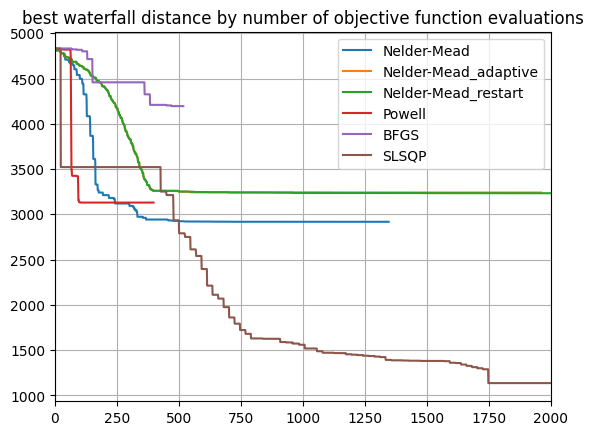

In [17]:
import itertools
import operator

plt.title("best waterfall distance by number of objective function evaluations")
plt.grid()
for method_name in ("Nelder-Mead", "Nelder-Mead_adaptive", "Nelder-Mead_restart", "Powell", "BFGS", "SLSQP"):
    plt.plot(list(itertools.accumulate((x[3] for x in results["no_regularization_" + method_name]), min)), label=method_name)
plt.legend()
plt.xlim((0, 2000))
plt.show()

In [12]:
indicators = np.copy(patient_indicators)
best_params = results["SLSQP"][0]
for p in results["SLSQP"]:
    if best_params[1] > p[1]:
        best_params = p
        
adjust_patient_indicators(indicators, best_params[0])

array([[1.00000000e+00, 4.22171083e-01, 5.79819062e-01, ...,
        2.77518134e+02, 1.19490102e+00, 5.17042709e-03],
       [1.00000000e+00, 4.97963711e-01, 2.02106260e+00, ...,
        2.40043061e+02, 1.24387735e+00, 8.79055401e-03],
       [1.00000000e+00, 4.69192219e-01, 2.87849290e-01, ...,
        2.61802382e+02, 1.39445997e+00, 5.23267814e-03],
       ...,
       [1.00000000e+00, 4.61623070e-01, 3.87701315e-01, ...,
        2.38901254e+02, 1.26328106e+00, 9.85370496e-03],
       [1.00000000e+00, 4.38601947e-01, 7.23122835e-01, ...,
        2.89684968e+02, 1.33374506e+00, 6.42820232e-03],
       [1.00000000e+00, 4.24192710e-01, 7.06626872e-01, ...,
        2.84310054e+02, 1.40970620e+00, 8.15104189e-03]])

In [13]:
from pathlib import Path

MODEL_PATH = Path("../qspRPlusC/simulateQSP.R").resolve()

# importing model
import os
from contextlib import redirect_stderr, redirect_stdout
from io import StringIO

from multiprocess import Process, Queue, cpu_count

from rpy2 import robjects
from rpy2.rinterface_lib.embedded import RRuntimeError
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage


END_VALUE = "end"


def load_r_model():
    """Loads R model from file and returns it as a python object."""
    model_path = MODEL_PATH
    cur_dir = Path.cwd()
    try:
        os.chdir(model_path.parent)
        with model_path.open("r") as f_p:
            model = SignatureTranslatedAnonymousPackage(f_p.read(), "model")
    finally:
        os.chdir(cur_dir)
    return model

r_model = load_r_model()

def calc_model_point(coord):
    global r_model
    stream = StringIO()
    err_stream = StringIO()
    try:
        with redirect_stdout(stream), redirect_stderr(err_stream):
            res = r_model.simulateQSP(robjects.FloatVector(coord))[0]
    except RRuntimeError as r_exception:
        raise ValueError(f"Error in simulation {r_exception.args[0]}") from r_exception
    stream.seek(0)
    err_stream.seek(0)
    if stream.read() or err_stream.read():
        raise ValueError("Unstable simulation")
    index = list(res.names).index("Tumor_volume")
    return list(res[index])

print(calc_model_point(indicators[0,:]))

def calc_model_point_mp(in_queue: Queue, out_queue: Queue):
    stream = StringIO()
    err_stream = StringIO()
    try:
        with redirect_stdout(stream), redirect_stderr(err_stream):
            r_model = load_r_model()
    except (RRuntimeError, FileNotFoundError) as e:
        out_queue.put((None, e))
        raise

    while True:
        input_data = in_queue.get()
        if input_data == END_VALUE:
            return

        i, coord = input_data
        try:
            res = calc_model_point(coord)
            out_queue.put((i, res))
        except ValueError as e:
            print(f"unstable {i}")
            res = [coord[10], *([100.0 * coord[10]] * 199)]
            out_queue.put((i, res))


def collect_result(
    out_queue: Queue, tumor_time_profiles: np.ndarray, progress_bar=None
):
    ind, data_row = out_queue.get(timeout=60)
    if ind is None:
        raise RuntimeError("Loading model fails") from data_row
    tumor_time_profiles[ind, :] = data_row
    if progress_bar is not None:
        progress_bar.update(1)


def model_predict_with_progress(input_data, progress_bar) -> np.array:
    print(f"calculating time profiles for {input_data.shape[0]} patients indicators")
    
    in_queue = Queue()
    out_queue = Queue()
    process_list = []
    process_num = cpu_count()

    for _ in range(process_num):
        proc = Process(target=calc_model_point_mp, args=(in_queue, out_queue))
        proc.start()
        process_list.append(proc)

    res_time_profiles = np.empty((input_data.shape[0], 200))
    calculated = 0

    try:
        for i, coord in enumerate(input_data):
            in_queue.put((i, coord))

            if i > 10 * process_num:
                collect_result(out_queue, res_time_profiles, progress_bar)
                calculated += 1

        while calculated < input_data.shape[0]:
            collect_result(out_queue, res_time_profiles, progress_bar)
            calculated += 1
    finally:
        for _ in range(process_num):
            in_queue.put(END_VALUE)

        for i in range(process_num):
            process_list[i].join()
    
    return res_time_profiles
            
from tqdm.notebook import tqdm

real_time_profiles = None
with tqdm(total=indicators.shape[0]) as pbar:
    time_profiles = model_predict_with_progress(indicators, pbar)
    real_time_profiles = time_profiles[time_profiles[:, 0] * 100.0 != time_profiles[:, 1], :]
    
print(f"calculated {real_time_profiles.shape}")

R[write to console]: Ładowanie wymaganego pakietu: deSolve

using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’


make: Nothing to be done for `all'.
[0.005170427090733827, 0.0034928894473846613, 0.002862229375618219, 0.0025258634547249805, 0.0023222605432602437, 0.0021907931140612447, 0.002102667998585049, 0.002042359239539407, 0.0020007463087386972, 0.0019721258112605985, 0.0019527592802873854, 0.001940106469294063, 0.0019323927514447274, 0.001928351710500665, 0.001927064496738559, 0.0019278559171131719, 0.0019302249417849444, 0.0019337969700210199, 0.001938290305687014, 0.0019434921780781163, 0.00194924133494849, 0.001955415254943809, 0.0019619206708593865, 0.0019686864605143336, 0.0019756583623760796, 0.0019827949282786, 0.0019900644870307544, 0.00199744283188114, 0.0020049114601871335, 0.0020124562313151356, 0.0020200663422184177, 0.002027733544519892, 0.0020354515494059714, 0.002043215555833024, 0.0020510219215022084, 0.0020588678798848987, 0.0020667513379983007, 0.0020746707194043085, 0.0020826248435604, 0.0020906128333971928, 0.0020986340445312583, 0.002106688011001638, 0.00211477440369727

  0%|          | 0/100000 [00:00<?, ?it/s]

calculating time profiles for 100000 patients indicators
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.


using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using SDK: ‘MacOSX13.3.sdk’
using SDK: ‘MacOSX13.3.sdk’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using SDK: ‘MacOSX13.3.sdk’
using SDK: ‘MacOSX13.3.sdk’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using 

calculated (100000, 200)


In [14]:
max_tumor_sizes =  real_time_profiles.max(axis=1)
final_tumor_sizes = real_time_profiles[:, -1]
final_tumor_sizes[final_tumor_sizes < 0] = 0
initial_tumor_sizes = indicators[:, 10]
r_percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
r_percent_change = r_percent_change[max_percent_change <= 100.0]
r_percent_change[::-1].sort()

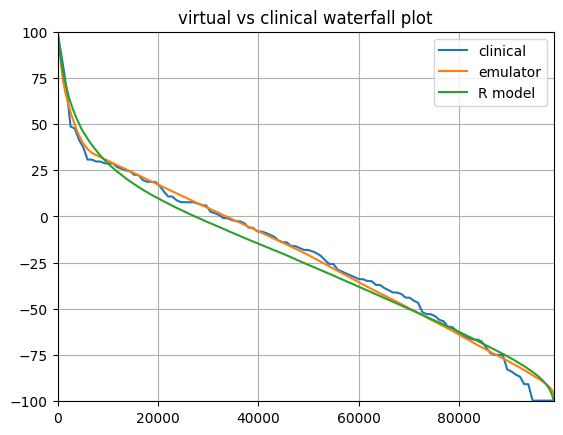

In [20]:
indicators = np.copy(patient_indicators)
best_params = results["no_regularization_SLSQP"][0]
for p in results["no_regularization_SLSQP"]:
    if best_params[3] > p[3]:
        best_params = p
        
adjust_patient_indicators(indicators, best_params[0])
virtual_waterfall_plot = waterfall_plot(indicators)
real_waterfall_plot = waterfall_plot_interpolation(np.arange(virtual_waterfall_plot.shape[0]) / (virtual_waterfall_plot.shape[0] - 1))

plt.title("virtual vs clinical waterfall plot")
plt.grid()
plt.xlim([0, virtual_waterfall_plot.shape[0] - 1])
plt.ylim([-100, 100])

plt.plot(real_waterfall_plot, label="clinical")
plt.plot(virtual_waterfall_plot, label="emulator")


r_percent_change_interpolation = interpolate.interp1d(
    np.arange(0, len(r_percent_change)) / (len(r_percent_change) - 1), r_percent_change
)

plt.plot(r_percent_change_interpolation(np.arange(virtual_waterfall_plot.shape[0]) / (virtual_waterfall_plot.shape[0] - 1)) , label="R model")

plt.legend()

plt.show()

In [19]:
from scipy.stats import kstest

print(f"ks test: {kstest(population_data, virtual_waterfall_plot, method='exact')}")
print(f"ks test: {kstest(population_data, r_percent_change, method='exact')}")

ks test: KstestResult(statistic=0.052452117204911226, pvalue=0.8848619574115602, statistic_location=-90.70567986, statistic_sign=1)
ks test: KstestResult(statistic=0.07559605793493612, pvalue=0.48745397876567237, statistic_location=-18.761997192722095, statistic_sign=-1)
